## ANA 500 - Mini Project 1 - Titanic
### Jeremy Krans

In [175]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as sm


In [66]:
# 1 Acquire

# Display
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)

# Files 
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"

# Read data
dtype_map = {"Ticket": "string", "Cabin": "string", "Name": "string", "Sex": "string", "Embarked": "string"}
train = pd.read_csv(TRAIN_PATH, dtype=dtype_map)
test  = pd.read_csv(TEST_PATH,  dtype=dtype_map)

# Shape and schema checks
print("Train shape:", train.shape)
print("Test  shape:", test.shape, "\n")

print("Train columns:", list(train.columns), "\n")
print("Test  columns:", list(test.columns), "\n")

print("Train info():")
train.info()
print("\nTest info():")
test.info()

# Uniqueness of PassengerId
print("\nPassengerId unique (train)?", train["PassengerId"].is_unique)
print("PassengerId unique (test)?",  test["PassengerId"].is_unique)

print("\nHead of train:")
print(train.head(5))

# Check missing
def missing_table(df, name="df"):
    m = df.isna().sum().sort_values(ascending=False)
    pct = (m/len(df)).round(3)
    out = pd.DataFrame({"n_missing": m, "pct_missing": pct})
    out.index.name = f"{name}_column"
    return out[out["n_missing"]>0]

print("\nMissing values (train):")
print(missing_table(train, "train"))

print("\nMissing values (test):")
print(missing_table(test, "test"))

# Data dictionary
data_dict = pd.DataFrame({
    "column": train.columns,
    "dtype":  [train[c].dtype for c in train.columns],
    "n_nonnull": [train[c].notna().sum() for c in train.columns],
    "n_unique":  [train[c].nunique(dropna=True) for c in train.columns]
}).sort_values("column").reset_index(drop=True)

print("\nData dictionary (train):")
print(data_dict)

# Descriptive queries 
if "Survived" in train.columns:
    # Survival rate overall
    surv_rate = train["Survived"].mean().round(3)
    print("\nOverall survival rate (train):", surv_rate)

    # Survival by Sex
    print("\nSurvival rate by Sex (train):")
    print(train.groupby("Sex")["Survived"].mean().round(3).sort_values(ascending=False))

    # Survival by Pclass
    print("\nSurvival rate by Pclass (train):")
    print(train.groupby("Pclass")["Survived"].mean().round(3))

# Category levels and counts
print("\nPclass counts (train):")
print(train["Pclass"].value_counts(dropna=False).sort_index())

print("\nSex counts (train):")
print(train["Sex"].value_counts(dropna=False))

print("\nEmbarked counts (train):")
print(train["Embarked"].value_counts(dropna=False))


data_dict.to_csv("titanic_data_dictionary_train.csv", index=False)

summary_tables = {
    "survival_by_sex.csv": train.groupby("Sex")["Survived"].mean().reset_index(),
    "survival_by_pclass.csv": train.groupby("Pclass")["Survived"].mean().reset_index(),
    "missing_train.csv": missing_table(train, "train").reset_index(),
    "missing_test.csv": missing_table(test, "test").reset_index()
}



Train shape: (891, 12)
Test  shape: (418, 11) 

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] 

Test  columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] 

Train info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    string 
 4   Sex          891 non-null    string 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    string 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    string 
 11  Embarked     889 non-null 

In [67]:
# 2 Prepare

# Handle missing values
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])
age_medians = train.groupby(["Pclass", "Sex"])["Age"].median()
train["Age"] = train.apply(
    lambda row: age_medians.loc[(row["Pclass"], row["Sex"])]
    if pd.isna(row["Age"])
    else row["Age"],
    axis=1
)
train["Fare"] = train["Fare"].fillna(train["Fare"].median())

# Create simple helper columns
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = (train["FamilySize"] == 1).astype(int)

# Verify cleaning
print("Missing values after cleaning:")
print(train.isnull().sum())

# Exploration of patterns
print("\nAverage survival rate by Sex:")
print(train.groupby("Sex")["Survived"].mean().round(2))

print("\nAverage survival rate by Pclass:")
print(train.groupby("Pclass")["Survived"].mean().round(2))

print("\nAverage survival rate by IsAlone (1 = alone):")
print(train.groupby("IsAlone")["Survived"].mean().round(2))


Missing values after cleaning:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

Average survival rate by Sex:
Sex
female    0.74
male      0.19
Name: Survived, dtype: float64

Average survival rate by Pclass:
Pclass
1    0.63
2    0.47
3    0.24
Name: Survived, dtype: float64

Average survival rate by IsAlone (1 = alone):
IsAlone
0    0.51
1    0.30
Name: Survived, dtype: float64


## Week 2 - Mini Project

This block of code visualizes the distribution of passenger ages to get an initial sense of the data’s shape and spread. A histogram is used to show how many passengers fall into each age range, and the blue curve (KDE) smooths the distribution to show where most passengers cluster.

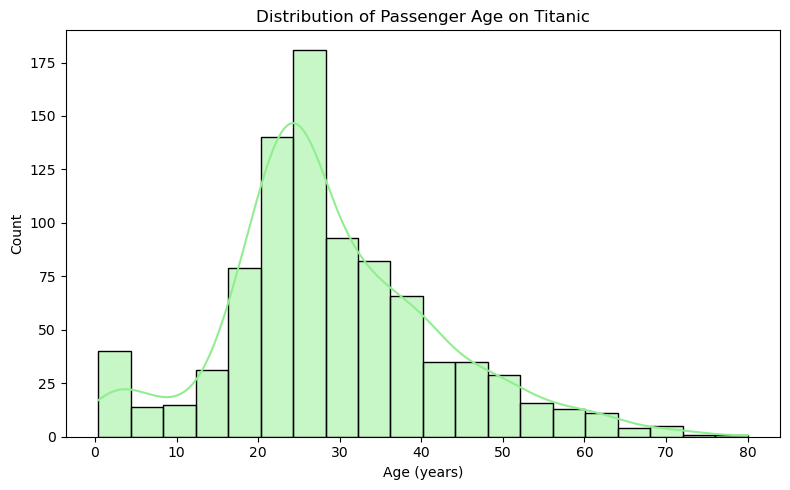

In [70]:
# plot age
plt.figure(figsize=(8, 5))
sns.histplot(train['Age'], bins=20, kde=True, color='lightgreen')
plt.title('Distribution of Passenger Age on Titanic')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The chart shows that most passengers were young adults between about 20 and 35 years old. There are fewer children and older passengers, with the number of passengers steadily decreasing after age 40. The distribution is right-skewed, meaning there were more younger passengers than older ones.
Missing ages were imputed using the median age grouped by passenger class and sex, so each missing entry was filled with the median age of passengers in the same Pclass and sex category.

---


This code creates a grouped bar chart that compares survival rates by both passenger class and gender. Using the barplot function, it calculates the average survival rate (0 = did not survive, 1 = survived) for each combination of class and gender, allowing quick comparison of how these two factors interact.

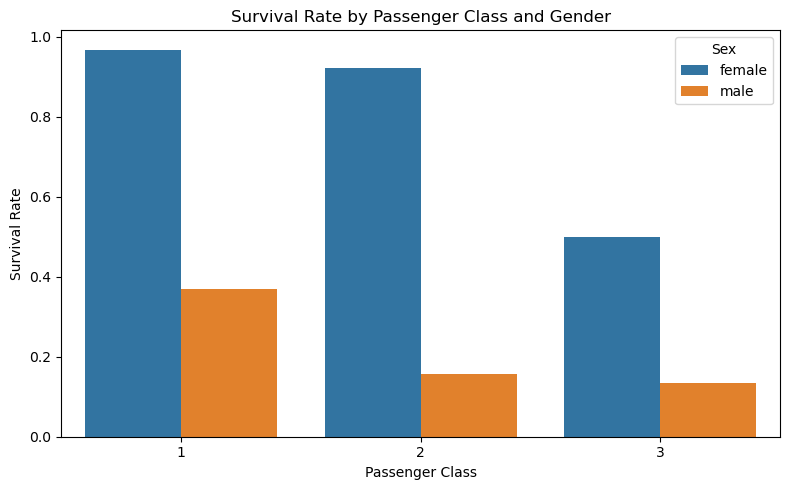

In [5]:
plt.figure(figsize=(8, 5))
sns.barplot(data=train, x='Pclass', y='Survived', hue='Sex', errorbar=None)
plt.title('Survival Rate by Passenger Class and Gender')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.tight_layout()
plt.show()


The bars reveal that women in 1st and 2nd class had the highest survival rates, while men in all classes had much lower survival probabilities, especially in 3rd class. Although a 3rd class woman still had a higher survival rate than any class of male.

---

This code block creates a grouped bar chart to compare survival rates by age group and passenger class. It uses sns.barplot().

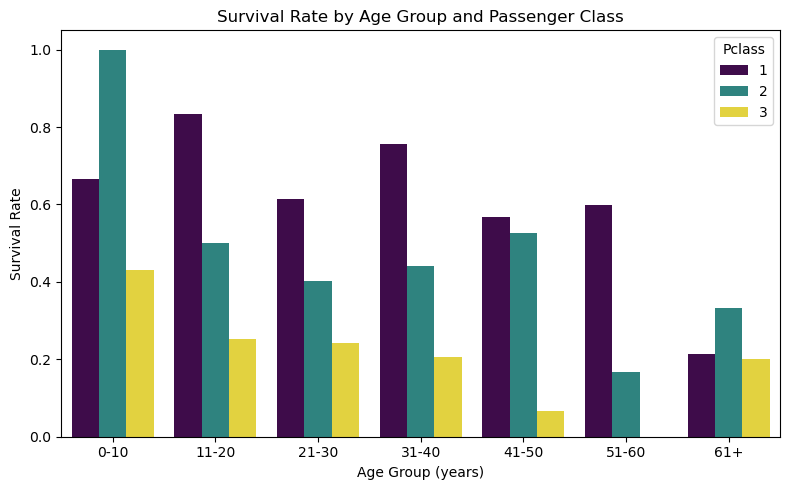

In [6]:
# Age bins and labels
bins = [0, 10, 20, 30, 40, 50, 60, 80]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61+']
train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

plt.figure(figsize=(8,5))
sns.barplot(data=train, x='AgeGroup', y='Survived', hue='Pclass', palette='viridis', errorbar=None)
plt.title('Survival Rate by Age Group and Passenger Class')
plt.xlabel('Age Group (years)')
plt.ylabel('Survival Rate')
plt.tight_layout()
plt.show()



The chart reveals that younger age groups (particularly ages 0-10 and 11-20) in first class had the highest survival rates. In contrast, the oldest age group (61+) across all classes had noticeably lower survival rates. The variation across classes shows that being in a higher passenger class strongly increased survival odds, especially among younger passengers.

---


This code block creates a bar chart comparing survival rates for passengers who traveled alone (IsAlone = 1) versus those who traveled with family (IsAlone = 0).

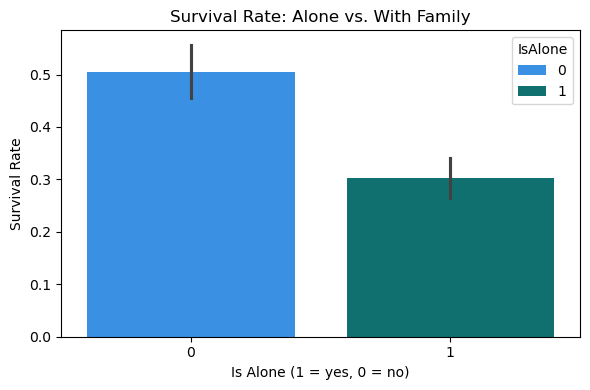

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(data=train, x='IsAlone', y='Survived', hue='IsAlone', palette=['dodgerblue','teal'])
plt.title('Survival Rate: Alone vs. With Family')
plt.xlabel('Is Alone (1 = yes, 0 = no)')
plt.ylabel('Survival Rate')
plt.tight_layout()
plt.show()


The chart shows that passengers traveling with family had a higher average survival rate than those traveling alone. This suggests that being part of a family group may have increased a passenger’s chances of surviving the disaster aboard the Titanic.

---

This block of code groups the data by two categorical variables; FamilySize (number of people aboard in the family group) and Pclass (passenger class 1st, 2nd, or 3rd), and computes the average survival rate for each combination. It then produces a bar chart with FamilySize on the x-axis, survival rate on the y-axis, and colors (hues) representing passenger class, so we can see how survival odds varied by family size within each class.

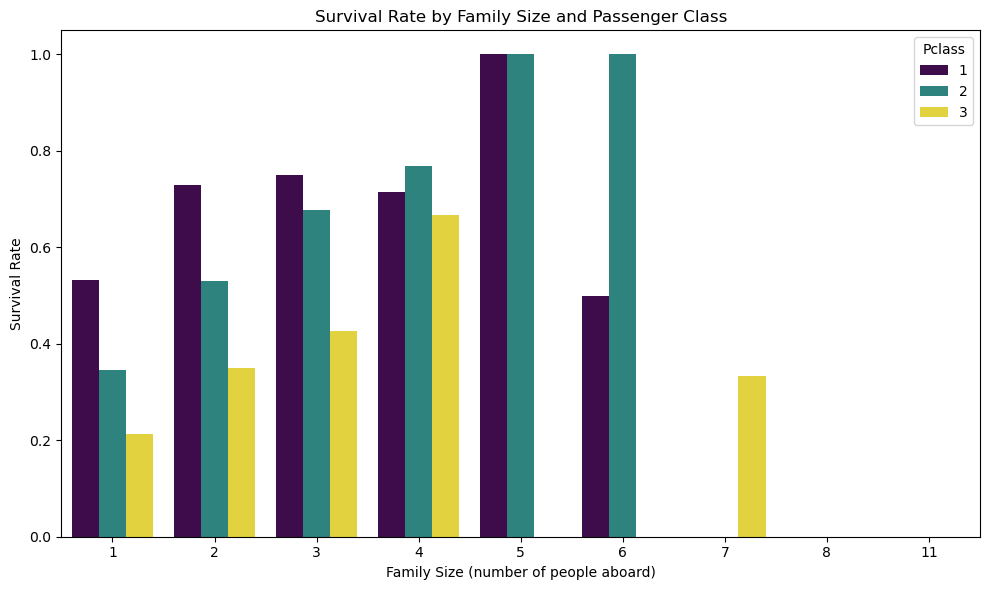

In [30]:
# Survival rate by FamilySize and Pclass
group_fs_pc = train.groupby(['FamilySize', 'Pclass'])['Survived'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=group_fs_pc, x='FamilySize', y='Survived', hue='Pclass', palette='viridis')
plt.title('Survival Rate by Family Size and Passenger Class')
plt.xlabel('Family Size (number of people aboard)')
plt.ylabel('Survival Rate')
plt.legend(title='Pclass')
plt.tight_layout()
plt.show()


In [13]:
# See how many passengers are in each FamilySize + Pclass combo
group_counts = (
    train
    .groupby(['FamilySize', 'Pclass'])
    .agg(PassengerCount=('PassengerId', 'size'))
    .reset_index()
    .sort_values(['FamilySize', 'Pclass'], ascending=[True, True])
)

print(group_counts)



    FamilySize  Pclass  PassengerCount
0            1       1             109
1            1       2             104
2            1       3             324
3            2       1              70
4            2       2              34
5            2       3              57
6            3       1              24
7            3       2              31
8            3       3              47
9            4       1               7
10           4       2              13
11           4       3               9
12           5       1               2
13           5       2               1
14           5       3              12
15           6       1               4
16           6       2               1
17           6       3              17
18           7       3              12
19           8       3               6
20          11       3               7


In the chart we can see a pattern: for smaller family sizes in higher classes, survival rates were relatively high. For example, first-class family groups of size 2–4 had strong survival rates. As family size grew larger (especially beyond 4 or 5) or as class dropped (toward 3rd class), survival rates declined.
I also confirmed with the grouped counts table that the “zero” survival rates in some cells are not just because there were no passengers in that group, there were passengers (for example 12 passengers in the 3rd class with family size 5) and all of them did not survive, hence the 0% rate.
Likewise, when you see very high bars (100%) or very low bars (0%) for some combinations, those often reflect very small sample sizes (e.g., one or two passengers), and so while visually striking they should be interpreted cautiously. 

---

This block of code uses plotly.express.scatter() to create an interactive scatter-plot with Fare on the X-axis and Age on the Y-axis. Each point represents a passenger. The size of each point is also set by Fare, and the color is determined by whether the passenger survived or did not. Hovering over points will reveal additional data like passenger class and gender.

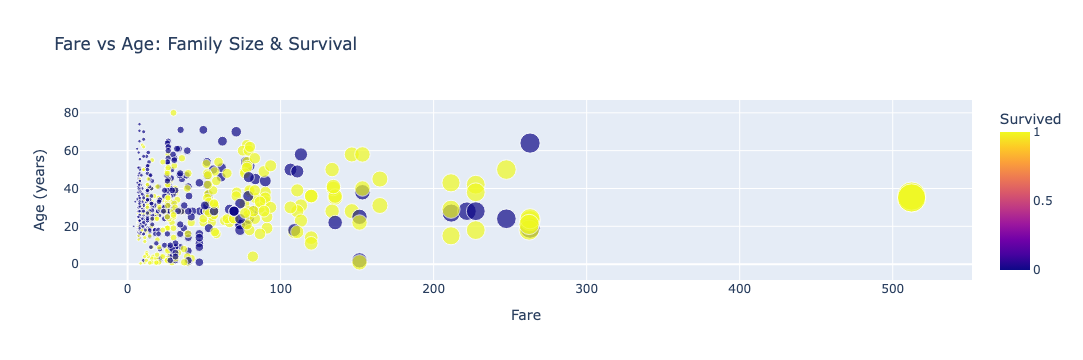

In [21]:
fig = px.scatter(
    train,
    x='Fare',
    y='Age',
    size='Fare',
    color='Survived',
    hover_data=['Pclass', 'Sex'],
    title='Fare vs Age: Family Size & Survival'
)
fig.update_layout(xaxis_title="Fare", yaxis_title="Age (years)")
fig.show()

The scatter-plot reveals how fare (likely proxy for class) and age correlate with survival. Higher-fare passengers tend to appear toward the right side of the chart, and many of those points are colored to indicate survival. Younger passengers cluster at lower ages and varied fares; older passengers or those who paid very low fares are often toward the bottom or left, with more points colored as non-survivors. The size encoding (fare) allows us to visually assess whether paying more increased survival chances, and the interactive hover data confirms that many of the high-fare, younger passengers who survived were also in higher classes or of a particular gender.

---

This chart shows the survival rate of children aged 12 and under aboard the Titanic, grouped by age bin (0-3, 4-6, 7-9, 10-12) and passenger class (1st, 2nd, 3rd).

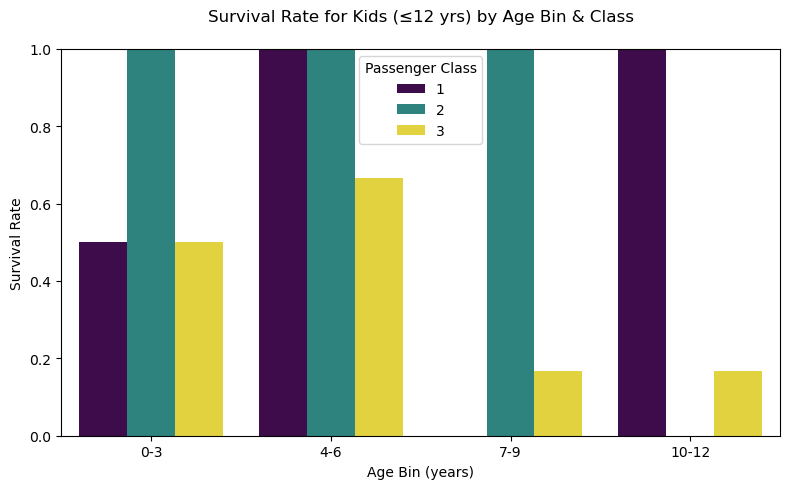

In [44]:
# Kids aged 12 and under
kids = train[ train['Age'] <= 12 ].copy()

# Age bins
bins = [0, 3, 6, 9, 12]
labels = ['0-3', '4-6', '7-9', '10-12']
kids['AgeBin'] = pd.cut(kids['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

# Group by age bin and class: compute count and survival rate
kids_stats = (
    kids
    .groupby(['AgeBin','Pclass'], observed=True)
    .agg(
        PassengerCount=('PassengerId', 'size'),
        SurvivalRate=('Survived', 'mean')
    )
    .reset_index()
)

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=kids_stats,
    x='AgeBin',
    y='SurvivalRate',
    hue='Pclass',
    palette='viridis',
    dodge=True  # ensure bars for each class are side-by-side
)

plt.title('Survival Rate for Kids (≤12 yrs) by Age Bin & Class', pad=20)
plt.xlabel('Age Bin (years)')
plt.ylabel('Survival Rate')
plt.ylim(0,1)
plt.legend(title='Passenger Class')
plt.tight_layout()
plt.show()


In [53]:
# Aged 12 and under
kids = train[train['Age'] <= 12].copy()

# Create age bins
bins = [0, 3, 6, 9, 12]
labels = ['0-3','4-6','7-9','10-12']
kids['AgeBin'] = pd.cut(kids['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Group by age bin + class + survival status
stats = (
    kids
    .groupby(['AgeBin', 'Pclass', 'Survived'], observed=False)
    .agg(PassengerCount=('PassengerId','size'))
    .reset_index()
)

# Pivot or reorder to compute survival rate per AgeBin + class
pivot = stats.pivot_table(index=['AgeBin', 'Pclass'], columns='Survived', values='PassengerCount', fill_value=0).reset_index()
pivot.columns = ['AgeBin', 'Pclass', 'DidNotSurvive', 'Survived']
pivot['Total'] = pivot['DidNotSurvive'] + pivot['Survived']
pivot['SurvivalRate'] = (pivot['Survived'] / pivot['Total']).round(3)

print(pivot)


   AgeBin  Pclass  DidNotSurvive  Survived  Total  SurvivalRate
0     0-3       1            1.0       1.0    2.0         0.500
1     0-3       2            0.0      10.0   10.0         1.000
2     0-3       3            9.0       9.0   18.0         0.500
3     4-6       1            0.0       1.0    1.0         1.000
4     4-6       2            0.0       4.0    4.0         1.000
5     4-6       3            4.0       8.0   12.0         0.667
6     7-9       1            0.0       0.0    0.0           NaN
7     7-9       2            0.0       3.0    3.0         1.000
8     7-9       3           10.0       2.0   12.0         0.167
9   10-12       1            0.0       1.0    1.0         1.000
10  10-12       2            0.0       0.0    0.0           NaN
11  10-12       3            5.0       1.0    6.0         0.167


The bars show survival rates for each age group and class. Note that very high survival rates (e.g., 100%) or very low ones are often due to small sample sizes (for example the 0-3-year group in 1st class had only 2 children). For children in 3rd class aged 0-3, of 18 children (n=18) only half survived. In the 4-6 age bin in 3rd class 12 children survived 8 (≈ 67%). These patterns suggest that younger children in higher classes had better outcomes, but small-group effects mean some results should be interpreted cautiously. Also note that the zero for 1st class 7-9 year olds and 2nd class 10-12 year olds are because there were no individuals in those class and age brackets, not that there were no survivors there. 

---

### Regression Model

#### Prepare the data  
Duplicated the cleaned dataset, convert the categorical `Sex` variable into a numeric form (`Sex_num`), and select the key features (`Pclass`, `Sex_num`, `Age`, `FamilySize`, `IsAlone`) along with the target variable `Survived`.  


In [123]:
model_df = train.copy()

# Convert sex to numeric (female = 1, male = 0)
model_df['Sex_num'] = (model_df['Sex'] == 'female').astype(int)

features = ['Pclass', 'Sex_num', 'Age', 'FamilySize', 'IsAlone']
X = model_df[features]
y = model_df['Survived']



#### Train the model  
Fit a logistic regression model.

In [124]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X, y)

LogisticRegression(max_iter=1000)

This code cleans and prepares the test dataset so it matches the structure and format of the training data. Filling in missing values and creating new numeric features that the model can understand.

In [174]:
test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])
age_medians = test.groupby(["Pclass", "Sex"])["Age"].median()
test["Age"] = test.apply(
    lambda row: age_medians.loc[(row["Pclass"], row["Sex"])]
    if pd.isna(row["Age"])
    else row["Age"],
    axis=1
)
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

test["Sex_num"] = (test["Sex"] == "female").astype(int)
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test["IsAlone"] = (test["FamilySize"] == 1).astype(int)

This code shows how strongly each feature influences survival in the logistic regression model, then uses that model to predict both the survival outcome and probability for each passenger in the test dataset.

In [126]:
# Feature coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Feature coefficients:")
print(coef_df)

# Test dataset
X_test = test[features]
test['Survived_Pred'] = logreg.predict(X_test)
test['Survived_Prob'] = logreg.predict_proba(X_test)[:, 1]


Feature coefficients:
      Feature  Coefficient
1     Sex_num     2.571862
2         Age    -0.041944
3  FamilySize    -0.381327
4     IsAlone    -0.700434
0      Pclass    -1.171197


The model suggests that being female (Sex_num = 1) greatly increases the chance of survival, while higher passenger class number, older age, larger family size, and being alone all decrease the likelihood of survival.

---

This code fits a logistic regression model using statsmodels, adds an intercept term, and then prints a detailed statistical summary showing each feature’s coefficient, standard error, z-score, p-value, and confidence interval — helping to see which variables significantly affect survival. The p value for fare was < 0.4 when I checked before, so I removed it from the model and created them again. Fare is likely just a proxy for class, so it wasn't helpful here. 

In [176]:
X_sm = sm.add_constant(X)
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.437765
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Mon, 10 Nov 2025   Pseudo R-squ.:                  0.3426
Time:                        22:42:58   Log-Likelihood:                -390.05
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.145e-85
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6349      0.548      6.631      0.000       2.561       4.709
Pclass        -1.2027      0.

The model fits well (Pseudo R² = 0.34) and all predictors are statistically significant (p < 0.01).
Being female (Sex_num) greatly increases survival odds, while higher passenger class (Pclass), older age, larger family size, and being alone (IsAlone) all reduce the likelihood of survival.

---

This code loads the actual survival data and merges it with the model’s predictions. It then checks how accurate the predictions are by printing accuracy, precision, recall, F1-scores, a confusion matrix, and the ROC AUC score to show overall model performance.

In [132]:
actual = pd.read_csv("test_survived.csv", dtype={"PassengerId": int, "Survived": int})

# Merge actual & predicted
comparison = actual.merge(
    test[['PassengerId', 'Survived_Pred', 'Survived_Prob']],
    on="PassengerId",
    how="inner"
)

print(comparison.head())

print("Accuracy:", accuracy_score(comparison['Survived'], comparison['Survived_Pred']))
print("Classification Report:")
print(classification_report(comparison['Survived'], comparison['Survived_Pred']))
print("Confusion Matrix:")
print(confusion_matrix(comparison['Survived'], comparison['Survived_Pred']))
print("ROC AUC Score:", roc_auc_score(comparison['Survived'], comparison['Survived_Prob']))

   PassengerId  Survived  Survived_Pred  Survived_Prob
0          892         0              0       0.073906
1          893         1              0       0.459710
2          894         0              0       0.075130
3          895         0              0       0.098536
4          896         1              1       0.623812
Accuracy: 0.9401913875598086
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       266
           1       0.92      0.91      0.92       152

    accuracy                           0.94       418
   macro avg       0.94      0.93      0.94       418
weighted avg       0.94      0.94      0.94       418

Confusion Matrix:
[[254  12]
 [ 13 139]]
ROC AUC Score: 0.9736100118717846


The model performed very well, correctly predicting survival about 94% of the time. Precision and recall are both strong for survivors and non-survivors, and the ROC AUC score of 0.97 shows excellent ability to separate the two groups. The confusion matrix confirms this, with only a small number of passengers misclassified.

---

This code creates a single test passenger with the given features and uses the logistic regression model to predict their probability of survival. It then prints that probability value, showing how likely the passenger is to survive based on the model.

In [178]:
X_test = pd.DataFrame([[2, 0, 4, 4, 0]], 
                      columns=['Pclass','Sex_num','Age','FamilySize','IsAlone'])
prob = logreg.predict_proba(X_test)[0, 1]
print("Survival probability:", prob)

Survival probability: 0.3725615467350245


Based on the raw data for 2nd class passenger survival (100%) and age getting lower correlating with higher survial rates, I was suspicious of this survival probability. It seems like since there are not many children compared to older passengers, Sex is pulling the survival probability down for male children too much. 

---

Get data on children survival rate by sex and class to check suspicious survival probability against raw survival data.

In [179]:
# Filter for children aged 12 or under
kids = train[train['Age'] <= 12].copy()

# Compute survival rate by sex and class
kids_stats = (
    kids
    .groupby(['Sex', 'Pclass'])['Survived']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={'count': 'PassengerCount', 'mean': 'SurvivalRate'})
)

print(kids_stats)


      Sex  Pclass  PassengerCount  SurvivalRate
0  female       1               1      0.000000
1  female       2               8      1.000000
2  female       3              23      0.478261
3    male       1               3      1.000000
4    male       2               9      1.000000
5    male       3              25      0.360000


The table shows 100% survival for 2nd class and 75% for 1st class. 3rd class is much lower, but even third class males is barely below the 37% prediction for a 2nd class 4 year old. I decided to test with random forest next to see if that gets a prediction result that makes more practical sense. 

---

This block creates the random forest model, tests on training data, and prints that accuracy as well as feature importance.

In [173]:
# Features and target
features = ['Pclass', 'Sex_num', 'Age', 'FamilySize', 'IsAlone']
X = model_df[features]
y = model_df['Survived']

# Create and fit the model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,          
    random_state=47
)
rf.fit(X, y)

# Predict on training data to get a baseline
y_pred = rf.predict(X)
print("Training Accuracy:", accuracy_score(y, y_pred))

# Feature importance
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

Training Accuracy: 0.8496071829405163
      Feature  Importance
1     Sex_num    0.503065
0      Pclass    0.189041
2         Age    0.180327
3  FamilySize    0.106365
4     IsAlone    0.021201


Training accuracy was good at ~85%. Sex is the most important feature for making predictions with class and age virtually tied and making up the bulk of the remaining 50%. Family size is about half as important to the model as class and age, while traveling alone status makes the smallest dent with about ~2% importance.

---

This is another code block for testing individual passenger's survival probability, but with the random forest model. Each array in the data frame represents a member of my family had we been on the titanic. My young sons, 4 and 8, and my wife and myself, each 39 years old.

In [180]:
# Predict survival for your test passenger
X_test = pd.DataFrame([[2, 0, 4, 4, 0],[2, 0, 8, 4, 0], [2, 1, 39, 4, 0], [2, 0, 39, 4, 0]],
                      columns=['Pclass','Sex_num','Age','FamilySize','IsAlone'])
probs = rf.predict_proba(X_test)[:, 1]
print("Survival probability:", probs)

Survival probability: [0.83111446 0.72006264 0.89719586 0.21336641]


This model does a better job predicting what we would have expected. Two young children and their mother with high probabilities of surviving while the older male, in this case me, with about 1:4 odds of survival. This is exactly what we would expect. 